# CV Project: Deep Learning for Camera Pose Estimation: A Comparative Study on 7-Scenes

## 1. Environment and Path Setup

In [ ]:
# demo.ipynb

import os
import argparse
import pandas as pd
import matplotlib.pyplot as plt

from train import train
from eval import evaluate
from geometry_baseline import run_baseline

DATA_ROOT = "/Users/zhengbinheng/Desktop/7-scenes-dataset"  
OUT_DIR = "runs/posenet_chess"
CKPT_PATH = os.path.join(OUT_DIR, "best.ckpt")
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)


## 2. Train PoseNet (Chess)

In [2]:
args = argparse.Namespace(
    data_root=DATA_ROOT,
    scene="chess",
    epochs=30,
    batch_size=32,
    lr=1e-4,
    beta=120.0,
    out=OUT_DIR
)
train(args)  # best.ckpt + loss


/opt/anaconda3/envs/node2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[1/30] avg_loss = 28.3060
[2/30] avg_loss = 6.6044
[3/30] avg_loss = 5.2792
[4/30] avg_loss = 4.4213
[5/30] avg_loss = 3.5573
[6/30] avg_loss = 3.2622
[7/30] avg_loss = 2.9794
[8/30] avg_loss = 2.7576
[9/30] avg_loss = 2.5401
[10/30] avg_loss = 2.2813
[11/30] avg_loss = 2.3134
[12/30] avg_loss = 2.1574
[13/30] avg_loss = 2.0245
[14/30] avg_loss = 2.0114
[15/30] avg_loss = 1.9840
[16/30] avg_loss = 1.8095
[17/30] avg_loss = 1.7561
[18/30] avg_loss = 1.7470
[19/30] avg_loss = 1.6819
[20/30] avg_loss = 1.5306
[21/30] avg_loss = 1.7153
[22/30] avg_loss = 1.5844
[23/30] avg_loss = 1.6611
[24/30] avg_loss = 1.5131
[25/30] avg_loss = 1.4581
[26/30] avg_loss = 1.4694
[27/30] avg_loss = 1.4465
[28/30] avg_loss = 1.4176
[29/30] avg_loss = 1.4955
[30/30] avg_loss = 1.3441
Training finished. Best loss = 1.3441
Results saved in runs/posenet_chess


### Visualize Training Curve

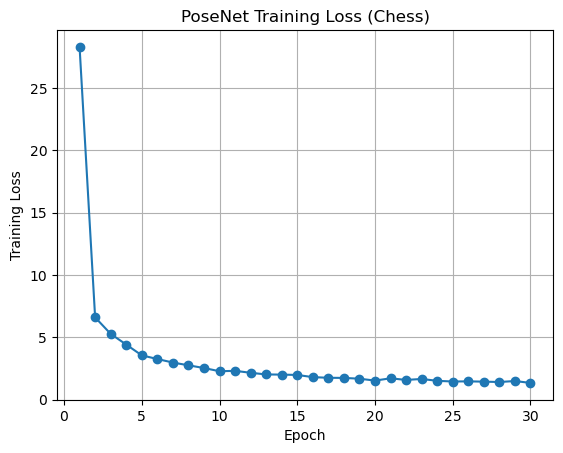

In [3]:
df_loss = pd.read_csv(os.path.join(OUT_DIR, "loss_curve.csv"))
plt.plot(df_loss["epoch"], df_loss["loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("PoseNet Training Loss (Chess)")
plt.grid(True)
plt.show()


## 3. PoseNet Testing and Generalization (fire + heads)

In [4]:
def run_eval(scene):
    args = argparse.Namespace(
        data_root=DATA_ROOT,
        scene=scene,
        ckpt=CKPT_PATH,
        out=os.path.join(RESULTS_DIR, f"{scene}_posenet.csv")
    )
    stats, df = evaluate(args)
    return stats, df

scenes = ["chess", "fire", "heads"]

pose_stats, pose_perframe = {}, {}
for s in scenes:
    stats, df = run_eval(s)
    pose_stats[s] = stats
    pose_perframe[s] = df


[PoseNet | chess] mean_t=0.198 m | median_t=0.151 m || mean_r=5.40° | median_r=4.55°
[PoseNet | fire] mean_t=0.933 m | median_t=0.920 m || mean_r=39.99° | median_r=35.66°
[PoseNet | heads] mean_t=0.807 m | median_t=0.769 m || mean_r=47.88° | median_r=46.98°


## 4. PnP+RANSAC Baseline

In [9]:
import importlib
import geometry_baseline

importlib.reload(geometry_baseline)

from geometry_baseline import run_baseline

def run_baseline_eval(scene):
    args = argparse.Namespace(
        data_root=DATA_ROOT,
        scene=scene,
        orb_kpts=4000,
        topk=10,
        ratio=0.75,
        min_match=20,
        reproj=5.0,
        iters=2000,
        conf=0.999
    )
    stats, df = run_baseline(args)
    return stats, df

base_stats, base_perframe = {}, {}
for s in scenes:
    stats, df = run_baseline_eval(s)
    base_stats[s] = stats
    base_perframe[s] = df

[chess/seq-03] building per-sequence DB ...
[chess|seq-03] mean_t=0.006 m | median_t=0.005 m || mean_r=0.25° | median_r=0.18° | inliers~1544.0
[chess/seq-05] building per-sequence DB ...
[chess|seq-05] mean_t=0.004 m | median_t=0.003 m || mean_r=0.17° | median_r=0.11° | inliers~1761.5
[PnP+RANSAC | chess] mean_t=0.005 m | median_t=0.004 m || mean_r=0.21° | median_r=0.14°
[fire/seq-03] building per-sequence DB ...
[fire|seq-03] mean_t=0.005 m | median_t=0.004 m || mean_r=0.18° | median_r=0.15° | inliers~1733.8
[fire/seq-04] building per-sequence DB ...
[fire|seq-04] mean_t=0.005 m | median_t=0.004 m || mean_r=0.23° | median_r=0.16° | inliers~1520.6
[PnP+RANSAC | fire] mean_t=0.005 m | median_t=0.004 m || mean_r=0.21° | median_r=0.15°
[heads/seq-01] building per-sequence DB ...
[heads|seq-01] mean_t=0.004 m | median_t=0.003 m || mean_r=0.24° | median_r=0.17° | inliers~1107.2
[PnP+RANSAC | heads] mean_t=0.004 m | median_t=0.003 m || mean_r=0.24° | median_r=0.17°


## 5. Results

### Comparison Table

In [10]:
summary = pd.DataFrame([
    {
        "Scene": s,
        "PoseNet mean_t (m)": pose_stats[s]["mean_t"],
        "PoseNet median_t (m)": pose_stats[s]["median_t"],
        "PoseNet mean_r (°)": pose_stats[s]["mean_r"],
        "PoseNet median_r (°)": pose_stats[s]["median_r"],
        "PnP+RANSAC mean_t (m)": base_stats[s]["mean_t"],
        "PnP+RANSAC median_t (m)": base_stats[s]["median_t"],
        "PnP+RANSAC mean_r (°)": base_stats[s]["mean_r"],
        "PnP+RANSAC median_r (°)": base_stats[s]["median_r"],
    }
    for s in scenes
])

summary.round(3)


,Scene,PoseNet mean_t (m),PoseNet median_t (m),PoseNet mean_r (°),PoseNet median_r (°),PnP+RANSAC mean_t (m),PnP+RANSAC median_t (m),PnP+RANSAC mean_r (°),PnP+RANSAC median_r (°)
0,chess,0.198,0.151,5.404,4.545,0.005,0.004,0.211,0.143
1,fire,0.933,0.920,39.992,35.665,0.005,0.004,0.206,0.153
2,heads,0.807,0.769,47.878,46.977,0.004,0.003,0.243,0.168


### Error Distribution Visualization (Histogram)

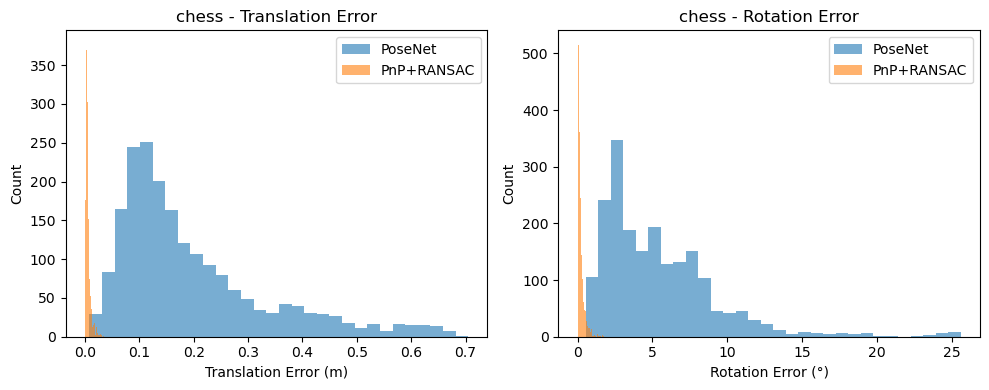

In [ ]:
scene = "chess"
df_pose = pose_perframe[scene]
df_base = base_perframe[scene]

plt.figure(figsize=(10, 4))

# Translation error
plt.subplot(1, 2, 1)
plt.hist(df_pose["t_err_m"], bins=30, alpha=0.6, label="PoseNet")
plt.hist(df_base["t_err_m"], bins=30, alpha=0.6, label="PnP+RANSAC")
plt.xlabel("Translation Error (m)")
plt.ylabel("Count")
plt.title(f"{scene} - Translation Error")
plt.legend()

# Rotation error
plt.subplot(1, 2, 2)
plt.hist(df_pose["r_err_deg"], bins=30, alpha=0.6, label="PoseNet")
plt.hist(df_base["r_err_deg"], bins=30, alpha=0.6, label="PnP+RANSAC")
plt.xlabel("Rotation Error (°)")
plt.ylabel("Count")
plt.title(f"{scene} - Rotation Error")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Export LaTeX table

latex_table = summary.round(3).to_latex(index=False)
with open(os.path.join(RESULTS_DIR, "summary_table.tex"), "w") as f:
    f.write(latex_table)

print("LaTeX table saved to results/summary_table.tex")

LaTeX table saved to results/summary_table.tex


### Framewise_error

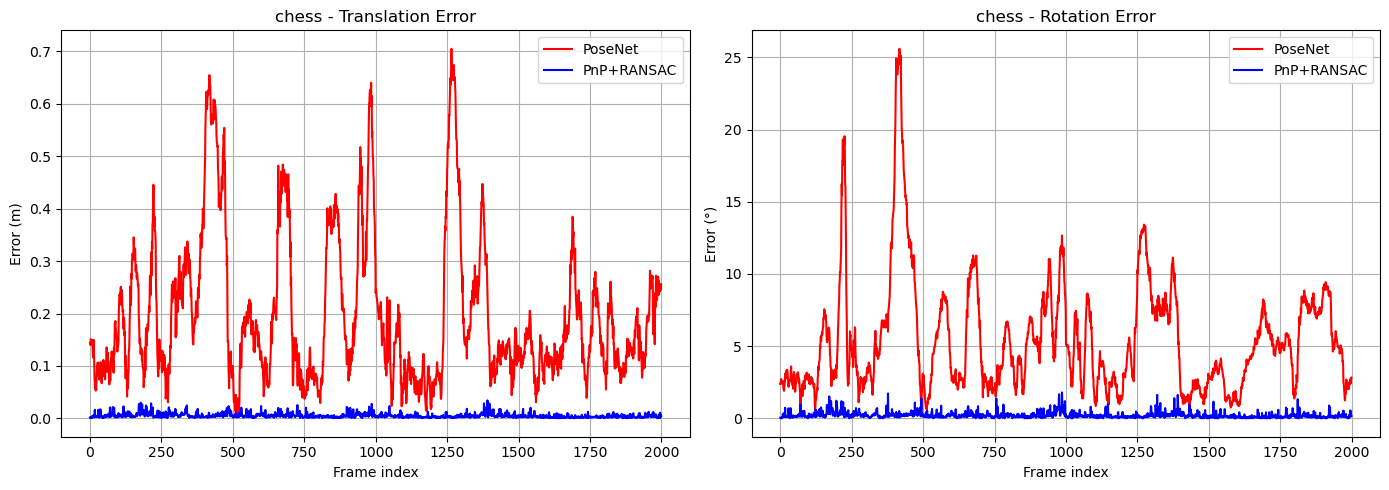

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

scene = "chess"
df_pose = pd.read_csv(f"results/{scene}_posenet_perframe.csv")
df_base = pd.read_csv(f"results/{scene}_baseline_perframe.csv")

# ---------- Translation error ----------
pose_diff = np.linalg.norm(df_pose[["t_pred_x","t_pred_y","t_pred_z"]].values -
                           df_pose[["t_gt_x","t_gt_y","t_gt_z"]].values, axis=1)
base_diff = np.linalg.norm(df_base[["t_pred_x","t_pred_y","t_pred_z"]].values -
                           df_base[["t_gt_x","t_gt_y","t_gt_z"]].values, axis=1)

# ---------- Rotation error (directly read) ----------
pose_r = df_pose["r_err_deg"].values
base_r = df_base["r_err_deg"].values

# ---------- Plot ----------
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharex=True)

# Translation error
axes[0].plot(pose_diff, label="PoseNet", color="r")
axes[0].plot(base_diff, label="PnP+RANSAC", color="b")
axes[0].set_title(f"{scene} - Translation Error")
axes[0].set_xlabel("Frame index")
axes[0].set_ylabel("Error (m)")
axes[0].grid(True)
axes[0].legend()

# Rotation error
axes[1].plot(pose_r, label="PoseNet", color="r")
axes[1].plot(base_r, label="PnP+RANSAC", color="b")
axes[1].set_title(f"{scene} - Rotation Error")
axes[1].set_xlabel("Frame index")
axes[1].set_ylabel("Error (°)")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

### Trajectory Visualization (GT vs PoseNet vs PnP+RANSAC)

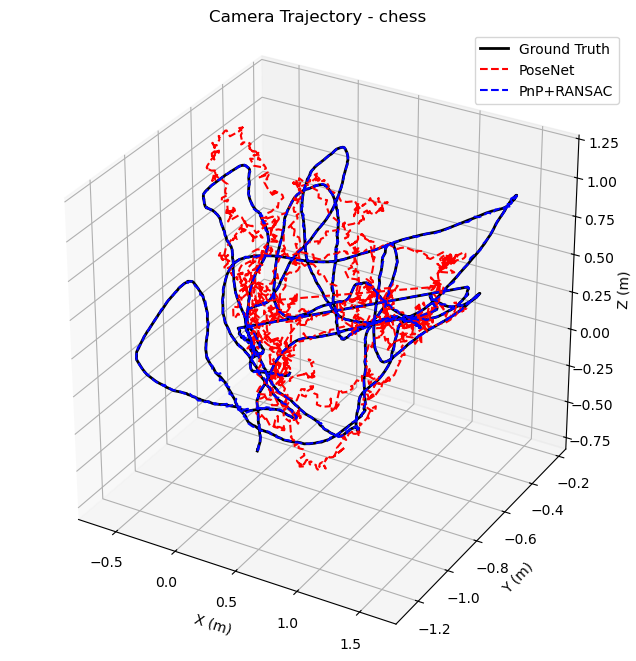

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import matplotlib.pyplot as plt

def plot_trajectory(scene):
    # Read results
    df_pose = pd.read_csv(f"results/{scene}_posenet_perframe.csv")
    df_base = pd.read_csv(f"results/{scene}_baseline_perframe.csv")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Ground Truth
    ax.plot(df_pose["t_gt_x"], df_pose["t_gt_y"], df_pose["t_gt_z"],
            "k-", linewidth=2, label="Ground Truth")

    # PoseNet
    ax.plot(df_pose["t_pred_x"], df_pose["t_pred_y"], df_pose["t_pred_z"],
            "r--", linewidth=1.5, label="PoseNet")

    # Baseline
    ax.plot(df_base["t_pred_x"], df_base["t_pred_y"], df_base["t_pred_z"],
            "b--", linewidth=1.5, label="PnP+RANSAC")

    ax.set_title(f"Camera Trajectory - {scene}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_box_aspect([1,1,1])  # Keep aspect ratio consistent
    ax.legend()
    plt.show()


# Plot trajectory for chess scene
plot_trajectory("chess")

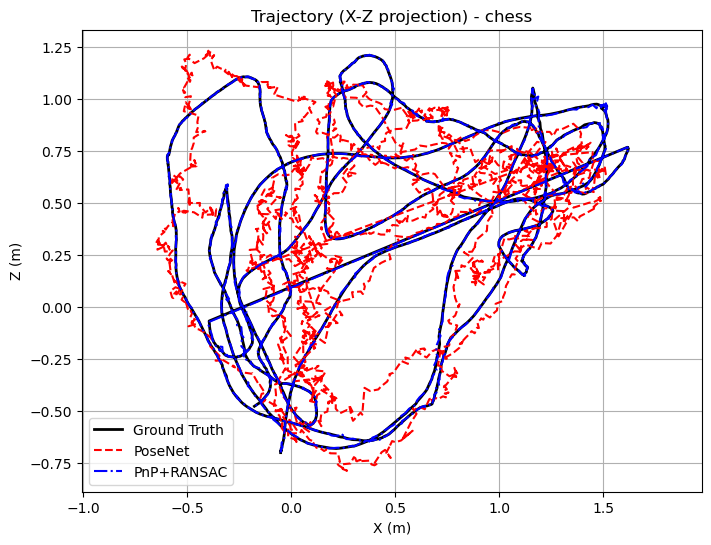

In [ ]:
def plot_trajectory_2d(scene):
    df_pose = pd.read_csv(f"results/{scene}_posenet_perframe.csv")
    df_base = pd.read_csv(f"results/{scene}_baseline_perframe.csv")

    plt.figure(figsize=(8,6))

    # Ground Truth
    plt.plot(df_pose["t_gt_x"], df_pose["t_gt_z"], "k-", linewidth=2, label="Ground Truth")

    # PoseNet
    plt.plot(df_pose["t_pred_x"], df_pose["t_pred_z"], "r--", linewidth=1.5, label="PoseNet")

    # Baseline
    plt.plot(df_base["t_pred_x"], df_base["t_pred_z"], "b-.", linewidth=1.5, label="PnP+RANSAC")

    plt.title(f"Trajectory (X-Z projection) - {scene}")
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.axis("equal")   # Keep aspect ratio consistent
    plt.legend()
    plt.grid(True)
    plt.show()


plot_trajectory_2d("chess")

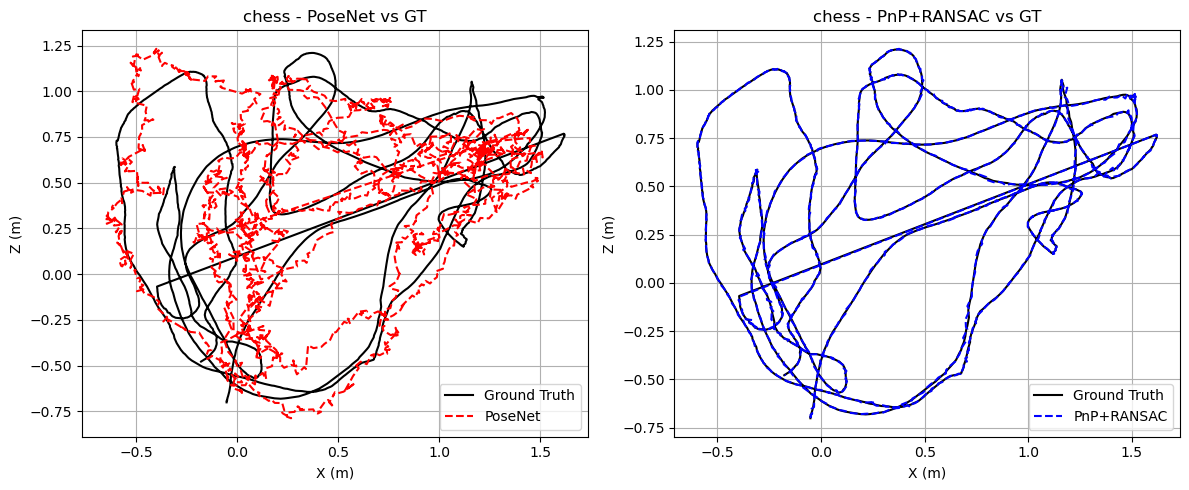

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_difference_trajectories(scene):
    # Read per-frame results
    df_pose = pd.read_csv(f"results/{scene}_posenet_perframe.csv")
    df_base = pd.read_csv(f"results/{scene}_baseline_perframe.csv")

    plt.figure(figsize=(12, 5))

    # PoseNet vs GT
    plt.subplot(1, 2, 1)
    plt.plot(df_pose["t_gt_x"], df_pose["t_gt_z"], "k-", label="Ground Truth")
    plt.plot(df_pose["t_pred_x"], df_pose["t_pred_z"], "r--", label="PoseNet")
    plt.title(f"{scene} - PoseNet vs GT")
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.legend()
    plt.grid(True)

    # Baseline vs GT 
    plt.subplot(1, 2, 2)
    plt.plot(df_base["t_gt_x"], df_base["t_gt_z"], "k-", label="Ground Truth")
    plt.plot(df_base["t_pred_x"], df_base["t_pred_z"], "b--", label="PnP+RANSAC")
    plt.title(f"{scene} - PnP+RANSAC vs GT")
    plt.xlabel("X (m)")
    plt.ylabel("Z (m)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_difference_trajectories("chess")

## 6. Effect of Different β Weights on PoseNet

In [43]:
import pandas as pd

# experimental results
data = {
    ("Chess", "mean_t"):   [0.180, 0.198, 0.196],
    ("Chess", "median_t"): [0.138, 0.151, 0.148],
    ("Chess", "mean_r"):   [5.508, 5.404, 5.408],
    ("Chess", "median_r"): [4.945, 4.545, 4.753],
    
    ("Fire", "mean_t"):   [0.936, 0.933, 0.981],
    ("Fire", "median_t"): [0.948, 0.920, 0.957],
    ("Fire", "mean_r"):   [38.758, 39.992, 40.742],
    ("Fire", "median_r"): [33.758, 35.665, 36.282],
    
    ("Heads", "mean_t"):   [0.879, 0.807, 0.816],
    ("Heads", "median_t"): [0.845, 0.769, 0.775],
    ("Heads", "mean_r"):   [47.716, 47.878, 47.732],
    ("Heads", "median_r"): [46.523, 46.977, 46.400],
}

columns = pd.MultiIndex.from_tuples(data.keys(), names=["Scene", "Metric"])

betas = [50, 120, 250]
df = pd.DataFrame(list(zip(*data.values())), index=betas, columns=columns)

df.index.name = "Beta"
df

Scene   Chess                            Fire                            \
Metric mean_t median_t mean_r median_r mean_t median_t  mean_r median_r   
Beta                                                                      
50      0.180    0.138  5.508    4.945  0.936    0.948  38.758   33.758   
120     0.198    0.151  5.404    4.545  0.933    0.920  39.992   35.665   
250     0.196    0.148  5.408    4.753  0.981    0.957  40.742   36.282   

Scene   Heads                            
Metric mean_t median_t  mean_r median_r  
Beta                                     
50      0.879    0.845  47.716   46.523  
120     0.807    0.769  47.878   46.977  
250     0.816    0.775  47.732   46.400

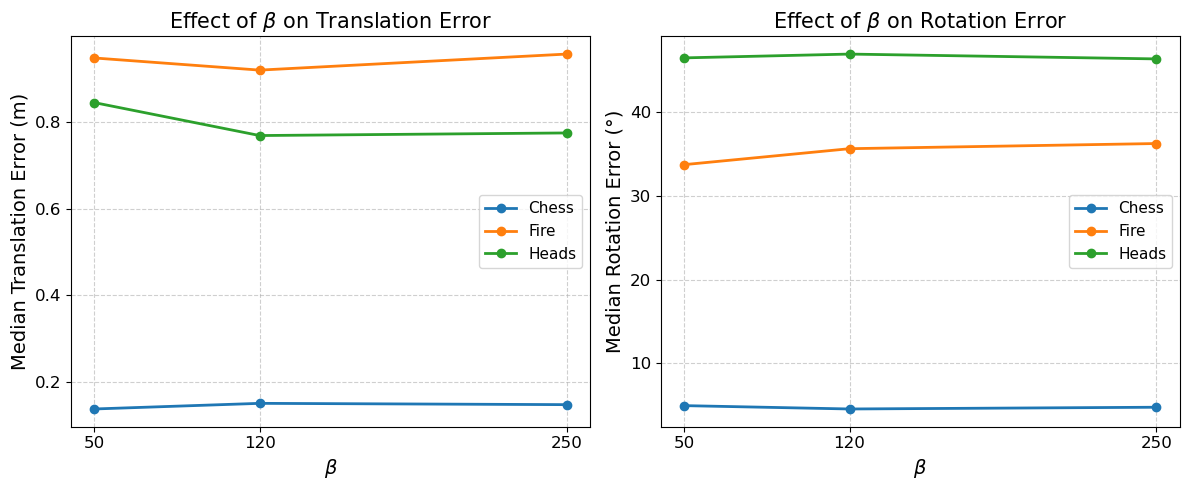

In [40]:
import matplotlib.pyplot as plt

betas = [50, 120, 250]

errors = {
    "Chess": {
        "translation": [0.138, 0.151, 0.148],
        "rotation":    [4.945, 4.545, 4.753],
    },
    "Fire": {
        "translation": [0.948, 0.920, 0.957],
        "rotation":    [33.758, 35.665, 36.282],
    },
    "Heads": {
        "translation": [0.845, 0.769, 0.775],
        "rotation":    [46.523, 46.977, 46.400],
    }
}

colors = plt.cm.tab10.colors  

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
for i, (scene, vals) in enumerate(errors.items()):
    plt.plot(betas, vals["translation"], marker="o", markersize=6,
             linewidth=2, color=colors[i], label=scene)
plt.xlabel(r"$\beta$", fontsize=14)
plt.ylabel("Median Translation Error (m)", fontsize=14)
plt.title("Effect of $\u03B2$ on Translation Error", fontsize=15)
plt.xticks(betas, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=11, loc="best")


plt.subplot(1,2,2)
for i, (scene, vals) in enumerate(errors.items()):
    plt.plot(betas, vals["rotation"], marker="o", markersize=6,
             linewidth=2, color=colors[i], label=scene)
plt.xlabel(r"$\beta$", fontsize=14)
plt.ylabel("Median Rotation Error (°)", fontsize=14)
plt.title("Effect of $\u03B2$ on Rotation Error", fontsize=15)
plt.xticks(betas, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=11, loc="best")

plt.tight_layout()
plt.savefig("ablation_plot.png", bbox_inches="tight")  
plt.show()